# Feature Selection using Recursive Feature Elimination Model (RFE) using Random Forest, Gradient Boosting, Logistic Regression,  and SVM

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, auc
import seaborn as sns  
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend

In [2]:
import numpy as np

In [3]:
data = pd.read_csv("datasets/cicids2017.csv")
data.columns = data.columns.str.replace(' ', '')
data.shape

(286467, 79)

In [4]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
data.shape


(286096, 79)

In [5]:
target = "Label"
x = data.loc[:, data.columns != target]
x.head()


,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0


In [6]:
y = data[target]
y.value_counts()


PortScan    158804
BENIGN      127292
Name: Label, dtype: int64

In [7]:
y = pd.factorize(y)[0]
pd.value_counts(y)

1    158804
0    127292
dtype: int64

## Univariate Feature Selection Using F-Test
For each feature we find its statistical significance to the target. Then we keep the features with the strongest statistical significance.

In [8]:
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0).fit(x)
x = x.loc[:, x.columns[constant_filter.get_support()]]
x.shape

(286096, 68)

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=0)

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif
select_k_best = SelectKBest(f_classif, k="all").fit(x_train, y_train)

In [11]:
f_test_scores = pd.DataFrame(
    dict(feature=x_train.columns, score=select_k_best.scores_))
f_test_scores.sort_values("score", ascending=False, inplace=True)
f_test_scores.to_csv("f-scores of features.csv", index=False)
f_test_scores


,feature,score
43,PSHFlagCount,402748.513269
35,MinPacketLength,95775.872270
11,BwdPacketLengthMin,54978.622854
48,AveragePacketSize,53074.613015
7,FwdPacketLengthMin,50416.442630
...,...,...
14,FlowBytes/s,352.934315
19,FlowIATMin,271.036904
46,ECEFlagCount,19.938896
42,RSTFlagCount,19.938896


## RFE with Random Forest

In [12]:
# from sklearn.feature_selection import RFECV
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(random_state=0, n_jobs=-1)
# rf_rfecv = RFECV(estimator=rf, step=1, scoring="accuracy", n_jobs=-1)


In [13]:
# %%time
# rf_rfecv = rf_rfecv.fit(x_train, y_train)


In [14]:
# print("Optimal number of features: ", rf_rfecv.n_features_)
# print("Best features: ", x_train.columns[rf_rfecv.support_])

In [15]:

# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score of number of selected features")
# plt.plot(range(1, len(rf_rfecv.grid_scores_) + 1), rf_rfecv.grid_scores_)
# plt.show()


## PCA

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train_pca = scaler.transform(x_train)
x_test_pca = scaler.transform(x_test)

In [17]:
from sklearn.decomposition import PCA

pca = PCA(.95)
pca.fit(x_train_pca)


PCA(n_components=0.95)

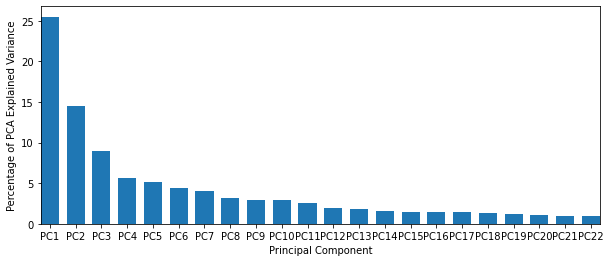

In [18]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ["PC" + str(x) for x in range(1, len(per_var) + 1)]
plt.bar(x=range(1, len(per_var) + 1), height=per_var,
        tick_label=labels, width=0.7,)

plt.ylabel("Percentage of PCA Explained Variance")
plt.xlabel("Principal Component")

plt.gca().margins(x=0)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.1
s = maxsize/plt.gcf().dpi*len(per_var)+2*m
margin = m/plt.gcf().get_size_inches()[0]
plt.gcf().subplots_adjust(left=margin, right=1.-margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

plt.savefig("images/explained pca variance.jpg", bbox_inches='tight')
plt.show()


In [19]:
x_train_pca = pca.transform(x_train_pca)
x_test_pca = pca.transform(x_test_pca)


## Classification Model Prediction with PCA Components

In [20]:
def generate_metrics(y_test, y_predicted, file_name):
    accuracy = accuracy_score(y_test, y_predicted)
    f_test_score = f1_score(y_test, y_predicted)
    precision_score_ = precision_score(y_test, y_predicted)
    recall_score_ = recall_score(y_test, y_predicted)
    confusion_matrix_df = pd.crosstab(
        pd.Series(y_predicted, name="Predicted"), pd.Series(y_test, name="Actual"))

    path = "./metrics/" + file_name

    with open(path, "w") as file:
        file.writelines(["Accuracy:\t" + str(accuracy),
                        "\nF1 Score:\t" + str(f_test_score),
                         "\nRecall Score:\t" + str(recall_score_),
                         "\nPrecision:\t" + str(precision_score_),
                         "\n\nConfusion Matrix\n",
                         confusion_matrix_df.to_string()
                         ])
    
    with open(path, "r") as file:
        print(file.read())


### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

random_forest_pca = RandomForestClassifier(random_state=0, n_jobs=-1)


In [51]:
%%time
random_forest_pca.fit(x_train_pca, y_train)


CPU times: total: 2min 36s
Wall time: 21.2 s


RandomForestClassifier(n_jobs=-1, random_state=0)

In [50]:
%%time
random_forest_pca_prediction = random_forest_pca.predict(x_test_pca)


CPU times: total: 844 ms
Wall time: 152 ms


In [52]:
generate_metrics(y_test, random_forest_pca_prediction,
                 "random forest with pca components.txt")


Accuracy:	0.9999126179657463
F1 Score:	0.9999214589780242
Recall Score:	0.9998743402865041
Precision:	0.9999685821106538

Confusion Matrix
Actual         0      1
Predicted              
0          25387      4
1              1  31828


### KNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn_pca = KNeighborsClassifier(n_jobs=-1)

In [23]:
%%time
# knn_pca.fit(x_train_pca, y_train)


CPU times: total: 46.9 ms
Wall time: 30.9 ms


KNeighborsClassifier(n_jobs=-1)

In [ ]:
%%time
knn_pca_prediction = knn_pca.predict(x_test_pca)


NameError: name 'knn_pca' is not defined

In [ ]:
generate_metrics(y_test, knn_pca_prediction, "knn with pca components.txt")


Accuracy:	0.9998077595246417
F1 Score:	0.9998272151799318
Recall Score:	0.9998115104297562
Precision:	0.9998429204234865

Confusion Matrix
Actual         0      1
Predicted              
0          25383      6
1              5  31826


### KNN using GridSearchCV

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {"n_neighbors": np.arange(1,9)}
knn_gscv = GridSearchCV(knn_pca, param_grid, cv=5)


In [ ]:
%%time
knn_gscv.fit(x_train_pca, y_train)


In [ ]:
print("Optimal value for k is: " + knn_gscv.best_params_)
print("Best score is: " + knn_gscv.best_score_)


In [ ]:
knn_gscv_optimal = KNeighborsClassifier(
    n_neighbors=knn_gscv.best_params_["n_neighbors"])


In [ ]:
%%time
knn_gscv_optimal.fit(x_train_pca, y_train)


In [ ]:
%%time
knn_gscv_prediction = knn_gscv_optimal.predict(x_test_pca)



In [ ]:
generate_metrics(y_test, knn_gscv_prediction,
                 "knn_gscv with pca components.txt")


### XGBoost

In [21]:
from xgboost import XGBClassifier

xgb_pca = XGBClassifier(n_estimators=100,n_jobs =-1)


In [22]:
%%time
xgb_pca.fit(x_train_pca, y_train)

CPU times: total: 2min 18s
Wall time: 20 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [23]:
%%time
xgb_pca_prediction = xgb_pca.predict(x_test_pca)

CPU times: total: 312 ms
Wall time: 59.8 ms


In [24]:
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(y_test, xgb_pca_prediction)))


0.010240041069473741


In [25]:
generate_metrics(y_test, xgb_pca_prediction, "xgb with pca components.txt")


Accuracy:	0.9998951415588955
F1 Score:	0.9999057492931196
Recall Score:	0.9998429253581301
Precision:	0.999968581123539

Confusion Matrix
Actual         0      1
Predicted              
0          25387      5
1              1  31827


### SVM

In [27]:
from sklearn.svm import SVC

svc_pca = SVC()


In [28]:
%%time
svc_pca.fit(x_train_pca, y_train)


CPU times: total: 2min 20s
Wall time: 2min 21s


SVC()

In [29]:
%%time
svc_pca_prediction = svc_pca.predict(x_test_pca)


CPU times: total: 17.5 s
Wall time: 17.7 s


In [30]:
generate_metrics(y_test, svc_pca_prediction, "svm with pca components.txt")


Accuracy:	0.9991611324711639
F1 Score:	0.9992460654038262
Recall Score:	0.9992774566473989
Precision:	0.999214676132437

Confusion Matrix
Actual         0      1
Predicted              
0          25363     23
1             25  31809


### Naive Bayes

In [31]:
from sklearn.naive_bayes import GaussianNB

gnb_pca = GaussianNB()


In [32]:
%%time
gnb_pca.fit(x_train_pca, y_train)


CPU times: total: 125 ms
Wall time: 137 ms


GaussianNB()

In [33]:
%%time
gnb_pca_prediction = gnb_pca.predict(x_test_pca)


CPU times: total: 62.5 ms
Wall time: 42.4 ms


In [34]:
generate_metrics(y_test, gnb_pca_prediction,
                 "naive bayes with pca components.txt")


Accuracy:	0.881789584061517
F1 Score:	0.9022656340307479
Recall Score:	0.9808368936918824
Precision:	0.8353488869863014

Confusion Matrix
Actual         0      1
Predicted              
0          19234    610
1           6154  31222


### Logistic Regression


In [40]:
from sklearn.linear_model import LogisticRegression

log_reg_pca = LogisticRegression(n_jobs=-1, max_iter=1000)


In [41]:
%%time
log_reg_pca.fit(x_train_pca, y_train)


CPU times: total: 141 ms
Wall time: 31.6 s


LogisticRegression(max_iter=1000, n_jobs=-1)

In [48]:
%%time
log_reg_pca_prediction = log_reg_pca.predict(x_test_pca)


CPU times: total: 15.6 ms
Wall time: 8.97 ms


In [46]:
generate_metrics(y_test, log_reg_pca_prediction,
                 "logistic regression with pca components.txt")


Accuracy:	0.9990562740300594
F1 Score:	0.9991519035054656
Recall Score:	0.9992774566473989
Precision:	0.9990263819095477

Confusion Matrix
Actual         0      1
Predicted              
0          25357     23
1             31  31809
